# Reddit API thread word 'scraper'
quick and dirty reddit threads keyword scraper.

### Importing the necessary libraries

In [277]:
# Getting the data
import praw

# Processing the data
import pandas as pd
import numpy as np
import os
import datetime
import time

# Visualizing the data
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud 

### Opening API id/secret file

In [278]:
with open ("apikey.txt") as api_info:
    credentials = api_info.readline().split(":")
    CLIENT_ID = credentials[0]
    CLIENT_SECRET = credentials[1]

USER_AGENT = f"python:{CLIENT_ID}:0.1 (by /u/Voidskiz)"

In [279]:
# Allows us to talk to the API through our API credentials
api = praw.Reddit(
    client_id = CLIENT_ID,
    client_secret = CLIENT_SECRET,
    user_agent = USER_AGENT
)

### Collecting reddit data 
Asking for user input (what to collect).

In [280]:
# User input
sub = input("Subreddit to search: ").strip()
query = input("Search Query: ").strip()
sortby = input("Sort by: ").strip()
timefilter = input("Timefilter: ").strip()

submissions = api.subreddit(sub).search(query, sort=sortby, time_filter=timefilter)
posts = []

# Getting a dictionary of the data we want to collect and putting them into a list.
def redditcall():
    for submission in submissions:
        item = {
            "title" : submission.title,
            "score" : submission.score,
            "comments" : submission.num_comments,
            "author" : submission.author,
            "time" : time.ctime(submission.created_utc),
            "id" : submission.id,
            "permalink": submission.permalink,
        }
        posts.append(item)
        
redditcall()

Subreddit to search: thenetherlands
Search Query: zeurdraad
Sort by: new
Timefilter: year


### Putting threads into dataframe for visibility, makes it easy to modify aswell. 
Checking if we got some valuable posts (and how many). Sorting by amount of comments, so we can get insight into how many actual useful threads we got (we want actual Zeurdraden..)

In [281]:
df = pd.DataFrame(posts)
sorted_df = df.sort_values("comments")
sorted_df.head(10)

,author,comments,id,permalink,score,time,title
7,woutervleeuwen,18,9yiyxp,/r/thenetherlands/comments/9yiyxp/dhl_bezorgin...,11,Mon Nov 19 18:41:22 2018,DHL bezorging duurt enorm lang. Zijn er meer m...
1,_ElBee_,90,a9lugw,/r/thenetherlands/comments/a9lugw/de_tweede_ke...,21,Wed Dec 26 06:25:08 2018,De Tweede Kerstdagse Ontbijt- en Ketstdinerdra...
0,damnitkevin,156,abowtf,/r/thenetherlands/comments/abowtf/de_eerste_ze...,27,Wed Jan 2 03:32:43 2019,De eerste zeurdraad van 2019
26,PsyQoWim,162,8qpq9g,/r/thenetherlands/comments/8qpq9g/de_zeurdraad/,21,Wed Jun 13 06:50:32 2018,De Zeurdraad
3,damnitkevin,190,a5f61o,/r/thenetherlands/comments/a5f61o/zeurdraad_ti...,23,Wed Dec 12 06:24:25 2018,Zeurdraad tijd! Het weekelijkse rondje gedeeld...
25,Jovbe,193,8sg09f,/r/thenetherlands/comments/8sg09f/de_zeurdraad/,18,Wed Jun 20 08:11:54 2018,De Zeurdraad
22,_ElBee_,198,8zt07y,/r/thenetherlands/comments/8zt07y/de_zeurdraad/,19,Wed Jul 18 08:27:55 2018,De Zeurdraad
23,damnitkevin,198,8vyudt,/r/thenetherlands/comments/8vyudt/zeurdraad/,26,Wed Jul 4 06:38:39 2018,Zeurdraad!
46,_ElBee_,211,7pe2qs,/r/thenetherlands/comments/7pe2qs/de_zeurdraad/,23,Wed Jan 10 08:37:35 2018,De Zeurdraad
45,damnitkevin,216,7qze0e,/r/thenetherlands/comments/7qze0e/zeurdraad_de...,30,Wed Jan 17 08:26:03 2018,Zeurdraad- de krijgen we vandaag weer een mons...


Now we clean up some useless threads and get insight in how much relevant threads we actually can collect.

In [282]:
c_posts = []

# Only getting posts with at least a few comments
for item in posts:
    if item["comments"] >= 20:
        c_posts.append(item)

# Getting threads with at least 20 comments 
posts_amount = len(posts)
c_posts_amount = len(c_posts)
print(f'{c_posts_amount}/{posts_amount} posts with 20 or more comments.')

46/47 posts with 20 or more comments.


In [283]:
# Into dataframe for easy mean calculation
df_c = pd.DataFrame(c_posts)

# Calculating mean for visualisation
mean_comments = df_c["comments"].mean()

### Visualizing thread activity

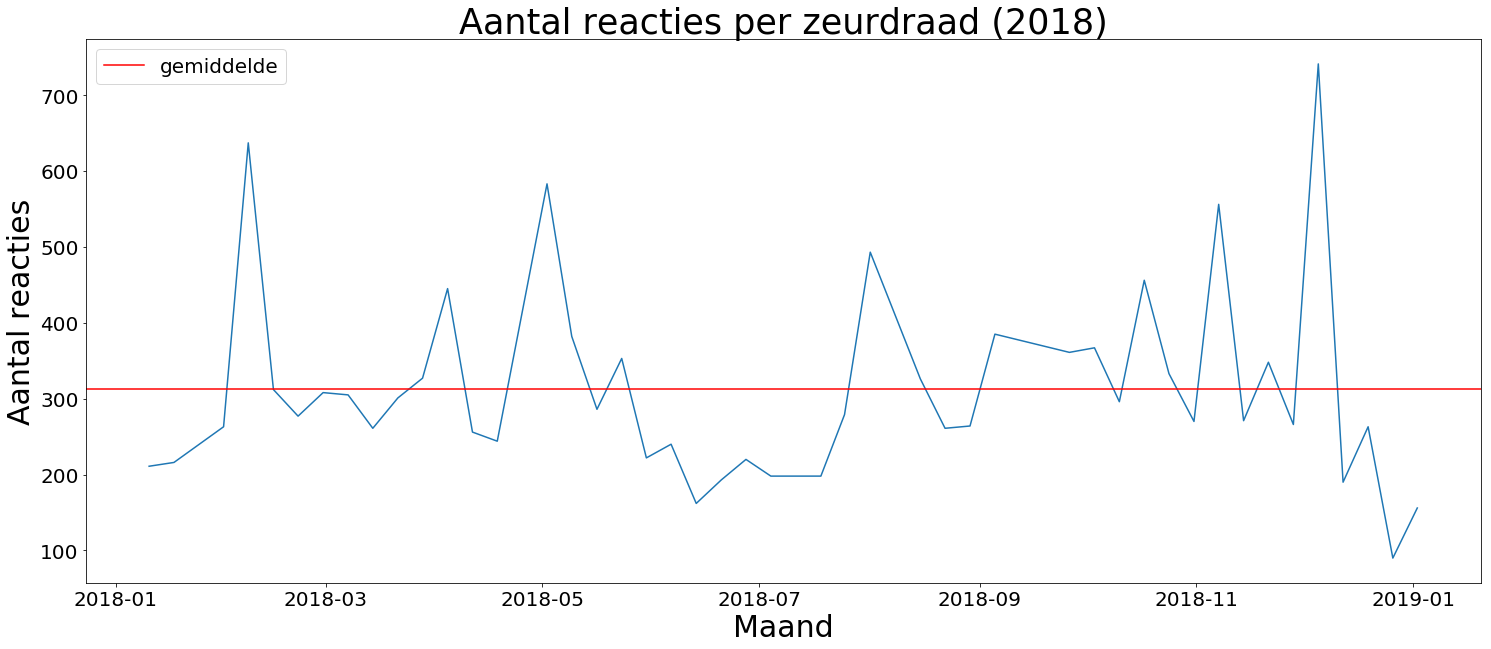

In [284]:
# Converting into pandas series and making the datetime function as pandas readable datetime. 
mean_comments_series = pd.Series(df_c["comments"])
mean_comments_series.index = pd.to_datetime(df_c["time"])

# Visualizing activity in threads
plt.figure(figsize=(25,10))
comments_lineplot = sns.lineplot(data = df_c["comments"])
comments_lineplot.tick_params(labelsize=20)

# Styling of lineplot
plt.axhline(mean_comments, 0, 100, color='red', label='gemiddelde')
plt.legend(fontsize=20)
plt.title(f"Aantal reacties per {query} (2018)",fontsize=35) 
plt.xlabel("Maand",fontsize=30)
plt.ylabel("Aantal reacties", fontsize=30)
plt.show

# Saving lineplot to file
plt.savefig(f"nr_of_replies_{query}.png")

### Getting thread comments

In [285]:
# Counting potential amount of comments we can scrape based on Reddit API data.
total = df_c["comments"].sum()
print(f'{total} comments totaal')

14372 comments totaal


NOTE: This number is including 'MoreComments' - which I am not scraping as it's a pain.
It still gives a good indicator of how much comments we can expect though.

In [286]:
# Scraping the actual comments from the individual Reddit Threads. Using the thread ID's to scrape each thread for comments. 
all_comments = []
current_thread = 0

for item in c_posts:
    page_id = item["id"]
    submission = api.submission(id=page_id)
    for comment in submission.comments:
        if isinstance(comment, praw.models.MoreComments):
            continue
        item = {
        "author" : comment.author,
        "score" : comment.score,
        "body": comment.body,
        "permalink" : comment.permalink
        }
        all_comments.append(item)
    
    #Giving some feedback on scraper progress
    current_thread = current_thread + 1
    print(f'Thread {current_thread} of {c_posts_amount} scraped for comments.')

print("\nScraping done.")    
    
# Putting comments into dataframe
all_df = pd.DataFrame(all_comments)

Thread 1 of 46 scraped for comments.
Thread 2 of 46 scraped for comments.
Thread 3 of 46 scraped for comments.
Thread 4 of 46 scraped for comments.
Thread 5 of 46 scraped for comments.
Thread 6 of 46 scraped for comments.
Thread 7 of 46 scraped for comments.
Thread 8 of 46 scraped for comments.
Thread 9 of 46 scraped for comments.
Thread 10 of 46 scraped for comments.
Thread 11 of 46 scraped for comments.
Thread 12 of 46 scraped for comments.
Thread 13 of 46 scraped for comments.
Thread 14 of 46 scraped for comments.
Thread 15 of 46 scraped for comments.
Thread 16 of 46 scraped for comments.
Thread 17 of 46 scraped for comments.
Thread 18 of 46 scraped for comments.
Thread 19 of 46 scraped for comments.
Thread 20 of 46 scraped for comments.
Thread 21 of 46 scraped for comments.
Thread 22 of 46 scraped for comments.
Thread 23 of 46 scraped for comments.
Thread 24 of 46 scraped for comments.
Thread 25 of 46 scraped for comments.
Thread 26 of 46 scraped for comments.
Thread 27 of 46 scrap

In [287]:
# Showing the last 10 comments, so we know how many comments the scraper actually collected.
all_df.tail(10)

,author,body,permalink,score
3542,FlyingNederlander,Ze hebben de trein die ik gebruik om naar huis...,/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,2
3543,palcatraz,Gelukkig van het overwerk af. Als ik nu mijn m...,/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,2
3544,funciton,Hier is een idee voor de volgende dienstregeli...,/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,2
3545,MrTinkiewinkie,Geslaagd voor me rijbewijs en een woonruimte g...,/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,5
3546,Kickass88,Promoveren is moeilijk :(\nAlle feedback die i...,/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,5
3547,None,[deleted],/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,2
3548,rodinj,Nog steeds bijzonder moe van het weekend en vo...,/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,1
3549,EzraSkorpion,Ik ben veel en veel te moe vandaag.,/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,1
3550,LordZikarno,Het was nat vanochtend. :(,/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,1
3551,TheGrumpyLion,"Had vanochtend 2 bezichtigingen in Hilversum, ...",/r/thenetherlands/comments/7pe2qs/de_zeurdraad...,1


### Getting most active posters / upvoted comments

In [288]:
# Most active commenters in these threads
most_frequent_commenters = all_df["author"].value_counts()
df_mfc = pd.Series(most_frequent_commenters)
df_mfc.head(5)

Sojoez                46
Chronocidal-Orange    40
VeryMuchDutch101      39
Agaesse               38
azupyon               37
Name: author, dtype: int64

In [289]:
# Highest rated comments
highest_scoring_comments = all_df.sort_values(by='score', ascending=False)
highest_scoring_comments.head(5)

,author,body,permalink,score
3252,yoshithetrex,Dat *tyfusgeluid* wat de deksels van de kleine...,/r/thenetherlands/comments/7vtsac/de_zeurdraad...,130
621,SnowCyclone,"Ik weet dat het vaker wordt gezegd, maar ik be...",/r/thenetherlands/comments/9uwmps/goede_zeurdr...,91
2379,Mossink,"Ik zit nu in Malacca, Maleisië en kan het moei...",/r/thenetherlands/comments/8gezj3/de_zeurdraad...,88
232,fnrux,Ik werd vandaag door 4 fietsers aan de kant ge...,/r/thenetherlands/comments/a39jkj/zeurdraad_ti...,86
2812,koektrom,"Hoewel ik hedenmorgen uitstekend geluimd ben, ...",/r/thenetherlands/comments/86086l/de_zeurdraad...,84


### Start of agressive cleaning of words 
Everything which doesnt fit the regex will be deleted, removing garbage.

In [290]:
# Cleaing up the data with some regexing (getting rid of meaningless junk symbols etc.)
all_df["body"] = all_df['body'].str.replace("[^ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ]", "")

# Also sorting by most common words, putting it into workable dataframe
topwords = pd.Series(" ".join(all_df["body"]).lower().split()).value_counts()[:1000]
topwords = pd.DataFrame(topwords)
topwords['actual_word'] = topwords.index
topwords = topwords.rename(columns={ topwords.columns[0]: "amount" })

In [291]:
# Showing the most common words
topwords.head(10)

,amount,actual_word
ik,7369,ik
de,5146,de
een,4957,een
het,4430,het
en,4197,en
dat,3052,dat
is,2734,is
te,2580,te
niet,2536,niet
maar,2429,maar


Shows that we have a lot of stopwords we have to deal with. Below we clean them up to get a more meaningful picture.

In [292]:
three_or_more = []
forbidden_words = ["flinke","situatie","meneer","huidige","hetzelfde","kwartier","compleet","kijk","pakken","klein","letterlijk","samen","eind","mogelijk","ineens","graag","deur","snel","bezig","blijkbaar","halen","bericht","geleerd","handen","kunt","haast","beneden","zomaar","vakken","erna","spullen","binnenkort","voren","waarin","voeren","vreemd","telkens","raken","muur","zometeen","kmu","zorgt","beschikbaar","voelde","gepland","tegelijk","vandaan","waard","los","fijne","algemeen","geprobeerd","neem","lig","gebruikt","volgend","kop","tien","juiste","tafel","eraan","reageren","buurt","ken","gebeurd","hoeveel","app","pakket","ervoor","koop","val","misen","minstens","meeste","terecht","behoorlijk","brengen","enzo","stop","afspraken","klinkt","tas","lag","goeie","stap","draaien","derde","eentje","hierdoor","doorheen","woorden","vlak","hangen","hoort","gevraagd","gekeken","normale","gebouw","past","minimaal","begon","qua","anderhalve","plus","handig","toevallig","jou","laatst","verschillende","gooien","zodra","verhaal","slechte","grond","momenteel","woord","draad","belangrijke","licht","enorme","betekent","genomen","naam","daarbij","kun","berhaupt","denkt","hoef","gebeurt","lees","daadwerkelijk","keuze","aangegeven","gebeuren","waarbij","ruim","tijdje","duidelijk","serieus","groep","viel","haal","vaker","volledig","uurtje","min","echte","ten","links","oke","vorig","jij","neer","daarvoor","erop","vertellen","mijzelf","aardig","standaard","gekomen","ruimte","weekje","den","tenminste","reactie","stellen","teveel","onderweg","huildige","wou","beide","vrije","gegeven","geef","tips","erbij","blijf","daardoor","elk","optie","kost","bleek","namelijk","vanmiddag","vier","merk","ontvangen","flink","sommige","weinig","waarvan","vanuit","ooit","zoek","nogal","ongeveer","ofzo","ipv","nadat","daarnaast","helft","ondanks","besloten","punt","meestal","opnieuw","gestuurd","verwacht","sowieso","ding","straks","vanaf","geval","plaats","rest","valt","totaal","lange","enorm","rijden","vast","mezelf","super","vragen","normaal","inmiddels","wist","zet","iedere","hou","mogen","maak","welke","ieder","gezegd","gebruik","behalve","meter","deel","helpt","stoppen","amper","kort","wereld","zojuist","constant","nummer","meerdere","edit","ene","meest","liever","enkele","zei","mocht","eruit","boven","midden","deed","zij","zie","oude","via","tweede","gemaakt","leuke","drie","tweede","goede","lukt","wij","loopt","wie","vol","etc","halve","sta","zeg","the","zag","nee","ons","zal","gekregen","kijken","toe","elkaar","per","klaar","zat","doe","kon","hun","kom","nou","erg","hem","pas","mag","weg","zit","wil","mij","dag","hij","net","zou","tot","mee","hoe","uur","had","uit","een","het","dat","van","heb","met","die","nog","aan","ook","wel","ben","dan","dus","wat","als","kan","was","bij","dit","beter","natuurlijk","eerste","gelukkig","leuk","lekker","goed","extra","eigen","volgens","blijven","jullie","kreeg","stond","gegaan","zelfs","hard","zodat","plan","plek","vaak","daarna","haar","jaren","blijft","geworden","nergens","aantal","ligt","onze","rond","maanden","maand","soms","houden","horen","vooral","langer","alsnog","blijkt","vond","voordat","hoor","vanwege","komende","tijdens","uiteindelijk","snap","zoeken","zetten","duurt","beste","dezelfde","loop","wilt","krijgt","kans","precies","aangezien","probeer","dicht","geeft","echter","sturen","meteen","nemen","ondertussen","eerder","probeer","einde","dicht","reden","kans","waarschijnlijk","dacht","naast","volgende","begin","gedaan","waardoor","vorige","nodig","moest","tijd","moment","kwam","half","kant","begint","sinds","ergens","heen","vinden","afgelopen","morgen","minuten","gister","denk","ging","gehad","open","soort","wilde","langs","binnen","hebt","wanneer","laatste","eerst","geleden","vervolgens","tegen","eerst","later","staat","krijg","nieuwe","bijna","terug","jaar","elke","verder","toen","terwijl","dagen","terwijl","weken","week","vandaag","twee","gisteren","NIEUWEWOORDEN>", "mensen","vind","gewoon","weer","zelf","iedereen","willen","laten","juist","that","word","staan","waren","artikel","werd","bent","geweest","zitten","weten","genoeg","ander","lang","persoon","best","gebruiken","hadden","bijvoorbeeld","tussen","hand","zitten","bent","geweest","waarom","zeggen","zoals","paar","misschien","zien","zich","altijd","naar","gezien","mijn","want","beetje","echt","niet","maar","zijn","voor","achter","over","onder","hebben", "door","meer","heeft","hier","geven","niets","niks","laat","eigenlijk","zullen","iemand","steeds","deleted","lijkt","komen","komt","geen","worden","wordt","helemaal","kunnen","alsof","even","deze","heel","alleen","hele","veel","waar","moeten","omdat","toch","worden","wordt","gaan","moet","andere","eens","doen","daar","iets","gaat","maken","nooit","allemaal","alle","manier","anders","grote","weet","dingen","denken","vraag","alles","this","enige","maakt","krijgen","doet","ziet","zegt","zouden","zonder","keer","alsof"]
# Eventueel eigen stopword list
# stopwords = pd.read_csv('stopwords.csv')

index = 0

for word in topwords["actual_word"]:
    freq = topwords["amount"][index]
    index = index + 1
    if len(word) >= 3 and word not in forbidden_words: # and word not in stopwords:
        item = {
            "word": word,
            "frequency": freq
        }
        three_or_more.append(item)

Checking below if we got some meaningful results now. Tweak forbidden word list and other parameters if needed. 

In [296]:
mcw_cleaned = pd.DataFrame(three_or_more)
print(mcw_cleaned.to_string())

     frequency                 word
0          330                 werk
1          216                  kut
2          191               werken
3          191                  zon
4          173                 huis
5          166             vakantie
6          153                trein
7          150                  zin
8          149                 auto
9          148                thuis
10         138               zeuren
11         131               wakker
12         130               school
13         129                 zeur
14         118                  bed
15         117                  man
16         115                 voel
17         113                 geld
18         107              wachten
19         106                leven
20         101            eindelijk
21         101                 vrij
22         100                vroeg
23          98             vriendin
24          98                 idee
25          95             tentamen
26          95              

### Visualizing word results

#### Bar graphs

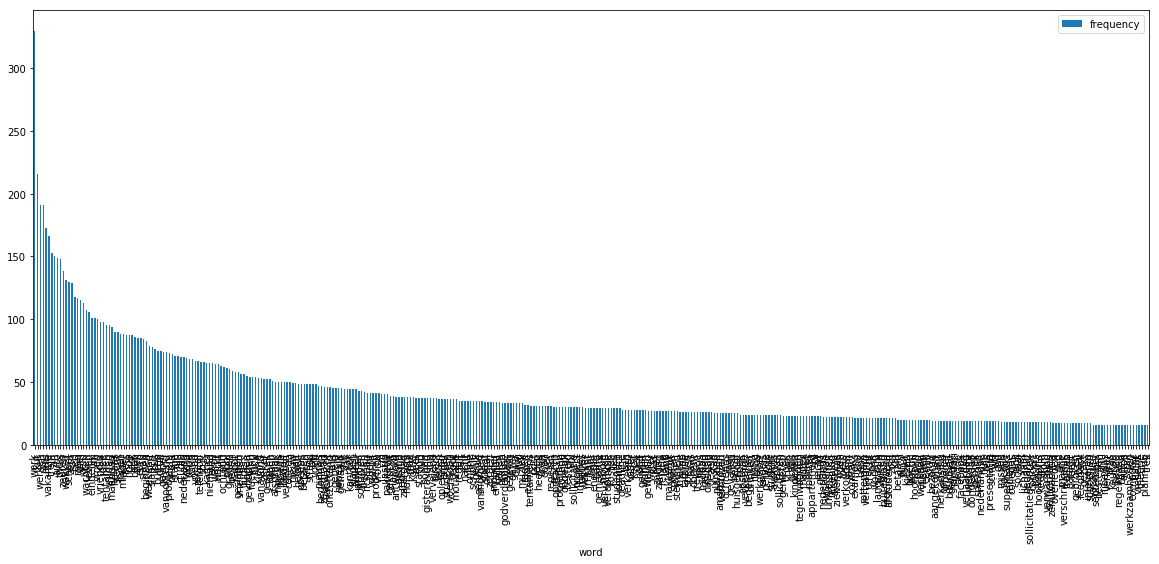

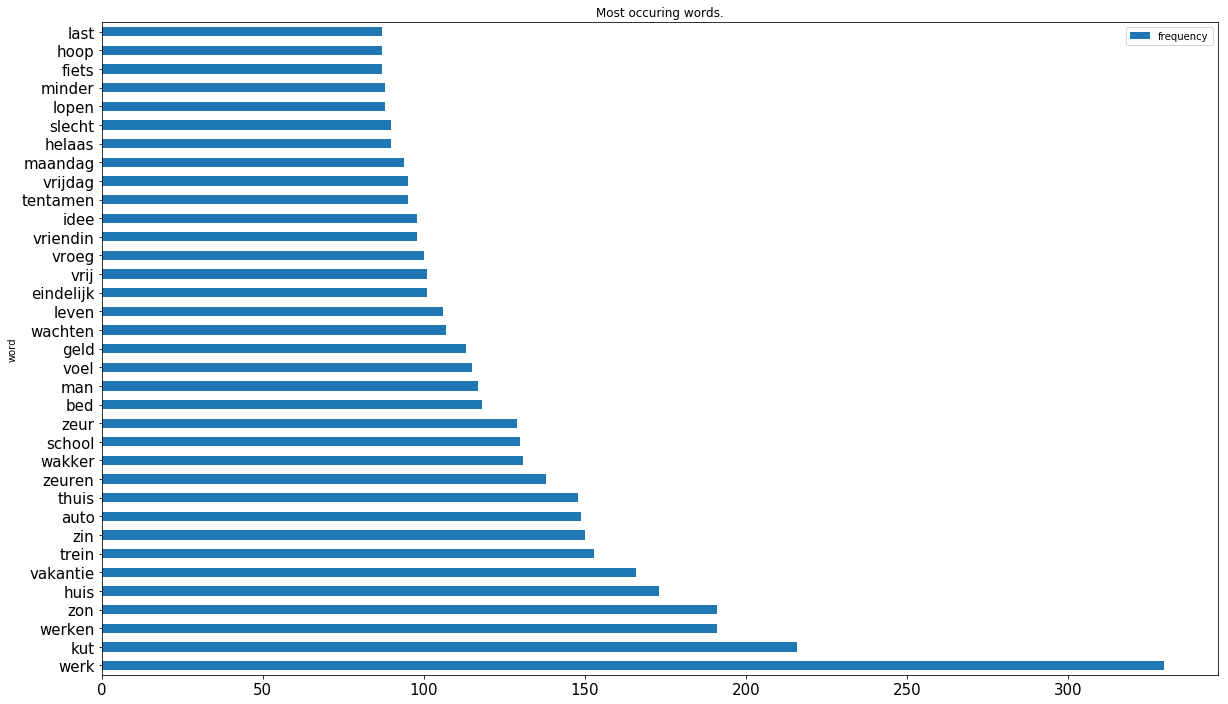

In [297]:
# Showing full distribution of words
all_words_bargraph = mcw_cleaned.plot(kind="bar",x="word",figsize=(20,8))

# Showing the top 
head_bargraph = mcw_cleaned.head(35).plot(kind="barh",x="word",figsize=(20,12), title="Most occuring words.", fontsize="15")

#### WordCloud

I redid this part a little bit because the way I did it before was awful. Reading documentation helps a lot haha.
WordCloud expects a string with all the words. The way I created that string before was just big yikes....

_Note to self: research 'WordCloud library (with) python dataframe'._

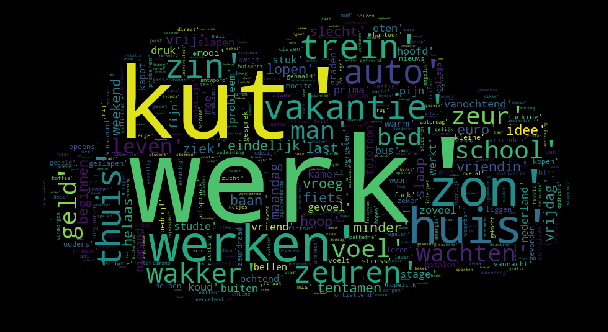

In [298]:
# Creating WordCloud and storing it into file
mask = np.array(Image.open("wordcloudBG.png"))
wc = WordCloud(background_color="black",mask=mask,max_words=400)
wc.generate(str(mcw_cleaned.values))
wc.to_file(f"WordCloud_{sub}_{query}.png")

# Showing in Jupiter doc aswell.
fig = plt.figure(figsize = (10, 7.5), facecolor = 'k', edgecolor = 'k')
plt.imshow(wc)
plt.axis('off')
plt.show()